In [1]:
import tensorflow as tf
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
from tensorflow.python.platform import gfile
from tensorflow.python.ops import io_ops
import os
import copy

import shutil
import datetime
from tqdm import tqdm
import sys

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

import h5py
import numpy as np

from utils import *
from random import shuffle

import IPython.display as ipd

In [2]:
label_words = []
with open('data/categories.txt') as f:
    label_words = f.read().splitlines()
print(label_words)
print(word2label('go', label_words))

['silence', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'bed', 'happy', 'sheila', 'three', 'eight', 'cat', 'dog', 'five', 'house', 'four', 'nine', 'marvin', 'six', 'zero', 'two', 'wow', 'bird', 'tree', 'one', 'seven']
10


In [3]:
data_dir = "/workspace/dataset/speech/train/audio"
BACKGROUND_NOISE_DIR_NAME = '_background_noise_'

config={}
config['window_size_ms'] = 30
config['window_stride_ms'] = 10.0
config['sample_rate'] = 16000
config['clip_duration_ms'] = 1000
config['dct_coefficient_count'] = 40

config['desired_samples'] = int(config['sample_rate'] * config['clip_duration_ms'] / 1000)
config['window_size_samples'] = int(config['sample_rate'] * config['window_size_ms'] / 1000)
config['window_stride_samples'] = int(config['sample_rate'] * config['window_stride_ms'] / 1000)

length_minus_window = (config['desired_samples'] - config['window_size_samples'])
if length_minus_window < 0:
    config['spectrogram_length'] = 0
else:
    config['spectrogram_length'] = 1 + int(length_minus_window / config['window_stride_samples'])
config['fingerprint_size'] = config['dct_coefficient_count'] * config['spectrogram_length']


In [5]:
data = h5py.File('data/dataset.hdf5','r')

background_dir = os.path.join(data_dir, BACKGROUND_NOISE_DIR_NAME)
noise = get_background_data(background_dir)

('/workspace/dataset/speech/train/audio/_background_noise_/pink_noise.wav', 960000)
('/workspace/dataset/speech/train/audio/_background_noise_/running_tap.wav', 978488)
('/workspace/dataset/speech/train/audio/_background_noise_/dude_miaowing.wav', 988891)
('/workspace/dataset/speech/train/audio/_background_noise_/exercise_bike.wav', 980062)
('/workspace/dataset/speech/train/audio/_background_noise_/doing_the_dishes.wav', 1522930)
('/workspace/dataset/speech/train/audio/_background_noise_/white_noise.wav', 960000)


In [6]:
def Model(num_classes,conf):
   
    dct_coefficient_count = conf['dct_coefficient_count']
    spectrogram_length = conf['spectrogram_length']
    fingerprint_size = dct_coefficient_count * spectrogram_length

    input_frequency_size = dct_coefficient_count
    input_time_size = spectrogram_length

    with tf.variable_scope('Model'):
        fingerprint_input = tf.placeholder(tf.float32, [None, fingerprint_size], name='features')
        dropout_prob = tf.placeholder(tf.float32, name='dropout_prob')
        is_training = tf.placeholder(tf.bool, name='is_training')
        lr_ = tf.placeholder(tf.float32, name='learning_rate')
        
        mfcc = tf.reshape(fingerprint_input,[-1, spectrogram_length, dct_coefficient_count, 1])

        conv1 = tf.layers.conv2d(mfcc, 64,(20,8), padding='same', activation=tf.nn.relu, name='conv1')
        pool = tf.layers.max_pooling2d(conv1, (2,2),(2,2))
        conv2 = tf.layers.conv2d(pool, 64,(10,4), padding='same', activation=tf.nn.relu, name='conv2')
        flat = tf.contrib.layers.flatten(conv2)
        drop = tf.layers.dropout(flat, rate=dropout_prob, training=is_training)
        

        logits =  tf.layers.dense(drop, num_classes, name='logits')

        ##--------------
        Y = tf.placeholder(tf.float32, [None, num_classes], name='target')
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
#         optimizer = tf.train.AdamOptimizer(lr_).minimize(loss)
        optimizer = tf.train.MomentumOptimizer(lr_,0.9).minimize(loss)

        correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(Y,1))
        acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    return fingerprint_input, Y, dropout_prob, lr_, logits, tf.nn.softmax(logits), loss, optimizer, acc,is_training

In [7]:
tf.reset_default_graph()
n_class = len(label_words)
X, Y, dropout_prob, lr, logits, pred, loss, optimizer, acc,is_training = Model(n_class,config)
wav_in, spectrogram_,mfcc_,spectrogram, mfcc = Features(config)
wav_, fg_volume_, sample_rate_, padding_, offset_, bg_, bg_volume_, augment = Augmenter(config)
getFeat = mfcc_

((1, 98, 257), (1, 98, 40))


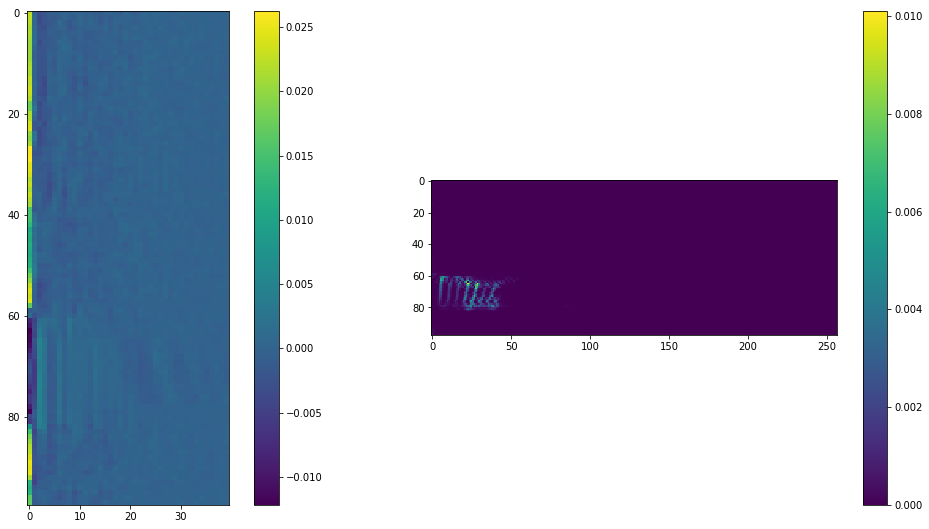

In [8]:
idx = 125
with tf.Session() as sess:
    spectro, mf = sess.run([spectrogram, mfcc], feed_dict={wav_in:data['X_train'][idx]})
    feat = sess.run(getFeat, feed_dict={wav_in:data['X_train'][idx]})
fsz = np.prod(feat.shape)
print(spectro.shape, mf.shape)
fig = plt.figure(figsize=(20, 20)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
ax0 = plt.subplot(gs[0])
plt.colorbar(ax0.imshow(mf[0]))
ax1 = plt.subplot(gs[1])
plt.colorbar(ax1.imshow(spectro[0]))

In [9]:
time_shift_ms = 100.0
sample_rate = config['sample_rate']
time_shift = int((time_shift_ms * sample_rate) / 1000)
choice = range(data['X_train'].shape[0])
shuffle(choice)

def next_train_batch(samples, target, bg_noise, idx, start, batch_sz, sess, labels, conf, augment, logmel, fsize, ncat,
                     wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_):

    if (start+batch_sz)>=samples.shape[0]:
        ndata = samples.shape[0]-start
    else:
        ndata = batch_sz  
    
    n_noise = 8 #batch_size :: 128 -> 4, 256 -> 8
    
    X = np.zeros((ndata+n_noise, fsize), dtype=np.float32)
    Y = np.zeros((ndata+n_noise, ncat), dtype=np.float32)
    
#     new_samples = []
    
    i = 0
    for k in xrange(ndata):
        time_shift_padding, time_shift_offset = get_time_shifts(time_shift)       
        bg_sample, bg_vol = get_noise(noise,1.0,0.1,conf['desired_samples'])
        
        input_dict = {
            wav_: samples[idx[start+k]],
            padding_: time_shift_padding,
            offset_: time_shift_offset,
            fg_volume_: 1.0,
            bg_: bg_sample,
            bg_volume_: bg_vol,
            sample_rate_: conf['sample_rate']
        }
        
        aug = sess.run(augment, input_dict)
        X[i, :] = sess.run(logmel, feed_dict={wav_in:aug}).flatten()
        Y[i,target[idx[start+k]]] = 1
        i+=1
    
    
    for k in xrange(n_noise): 
        max_vol = 1.0
        if k >n_noise*0.5:
            max_vol = 0.1
            
        bg_sample, bg_vol = get_noise(noise,1.0,max_vol,conf['desired_samples'])
        if k== 0:
            bg_sample = np.zeros_like(bg_sample)
        
        input_dict = {
            wav_: bg_sample,
            padding_: time_shift_padding,
            offset_: time_shift_offset,
            fg_volume_: 0.0,
            bg_: bg_sample,
            bg_volume_: bg_vol,
            sample_rate_: conf['sample_rate']
        }
        
        aug = sess.run(augment, input_dict)
        X[i, :] = sess.run(logmel, feed_dict={wav_in:aug}).flatten()
        Y[i,0] = 1
        i+=1

    return X,Y#, new_samples
      
with tf.Session() as sess:        
    x_batch,y_batch= next_train_batch(data['X_train'],data['Y_train'],noise, choice,
                                      0,4, sess, label_words, config,augment, getFeat, fsz,
                                      n_class,wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_)
    print(np.argmax(y_batch,1))
    for i in range(x_batch.shape[0]):
        print(x_batch[i,:3])
    

[ 5 30  7  2  0  0  0  0  0  0  0  0]
[-2.78112316  0.41778931  1.13059473]
[-10.6968689   -0.72623998   1.17804694]
[-23.33384895  -3.90486217  -0.17854978]
[-23.85321426  -1.08206415   0.93579525]
[ -2.47139359e+02   8.88178420e-16   2.22044605e-14]
[ 19.04308128  -0.46657717  -0.13929695]
[ 20.73814011  -3.7105391    0.15791379]
[ 5.1516614  -3.50805449  0.24816558]
[ 4.50897455 -3.12227154  1.55794263]
[-28.68687248  -1.59266412   0.82896298]
[-21.12672997  -0.15936658   0.89506423]
[-3.25806165 -3.78020954 -0.3198314 ]


In [10]:
def next_val_batch(samples, target, start, batch_sz, sess, labels, conf, augment, logmel, fsize, ncat,
                     wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_):

    if (start+batch_sz)>=samples.shape[0]:
        ndata = samples.shape[0]-start
    else:
        ndata = batch_sz  
    
    X = np.zeros((ndata, fsize), dtype=np.float32)
    Y = np.zeros((ndata, ncat), dtype=np.float32)
    
    for k in xrange(ndata):
        
        X[k, :] = sess.run(logmel, feed_dict={wav_in: samples[start+k]}).flatten()
        Y[k,target[start+k]] = 1
        
    return X,Y#, new_samples

with tf.Session() as sess:
    batch_x,batch_y= next_val_batch(data['X_val'],data['Y_val'], 0,4, sess, label_words, 
                                                  config,augment, getFeat, fsz,n_class,
                                                  wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_)
    print(np.argmax(batch_y,1))            

[9 9 9 9]


### Training

In [11]:

tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", acc)

# visualize the weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

log_training = tf.summary.merge_all()

n_epochs = 20
dropout = 0.5
batch_size = 256-8
model_file = "./trained/all.model"
logs_path = './logs/'

saver = tf.train.Saver()


INFO:tensorflow:Summary name Model/conv1/kernel:0 is illegal; using Model/conv1/kernel_0 instead.
INFO:tensorflow:Summary name Model/conv1/bias:0 is illegal; using Model/conv1/bias_0 instead.
INFO:tensorflow:Summary name Model/conv2/kernel:0 is illegal; using Model/conv2/kernel_0 instead.
INFO:tensorflow:Summary name Model/conv2/bias:0 is illegal; using Model/conv2/bias_0 instead.
INFO:tensorflow:Summary name Model/logits/kernel:0 is illegal; using Model/logits/kernel_0 instead.
INFO:tensorflow:Summary name Model/logits/bias:0 is illegal; using Model/logits/bias_0 instead.


In [12]:
cnt = 0
if os.path.exists(logs_path) and cnt==0:
    shutil.rmtree(logs_path)

n_data = data['X_train'].shape[0]
n_iter = int(np.ceil(n_data/float(batch_size)))


with tf.Session() as sess:     
    if cnt ==0 :
        sess.run(tf.global_variables_initializer())  # init
    else:
        saver.restore(sess, model_file)
        
    # tensorboard writer
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for epoch in xrange(n_epochs):
        with tqdm(total=n_iter, file=sys.stdout) as pbar:
            
            # get the learning rate
            f = open('training_config.txt', 'r')
            learning_rate = float(f.readline())
            dropout = float(f.readline())
            f.close()

            
            shuffle(choice)
            ma_acc,ma_loss,n, v_acc = 0,0,0,0
            for i in range(0, n_data, batch_size):
                batch_x,batch_y = next_train_batch(data['X_train'],data['Y_train'],noise, choice,
                                      i,batch_size, sess, label_words, config,augment, getFeat, fsz,
                                      n_class,wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_)
                
                # run the optimization
                feed_dict={X: batch_x, Y: batch_y, dropout_prob: dropout, lr: learning_rate, is_training: True}
                train_loss, _, train_acc, summary, res = sess.run([loss, optimizer, acc, log_training, pred],feed_dict)

                ma_acc += train_acc*batch_x.shape[0]
                ma_loss += train_loss*batch_x.shape[0]

                n += batch_x.shape[0] 
                pbar.set_description("%i/%i loss:%f acc:%02.03f val:%02.03f lr=%f" 
                                     % (epoch, n_epochs,ma_loss/n, ma_acc/n*100,v_acc*100,learning_rate))
                pbar.update(1)

                summary_writer.add_summary(summary, cnt)
                cnt += 1
        
            ma_loss /= n
            ma_acc /= n
            
            # validation
            
            v_acc,n = 0,0
            for i in range(0, data['X_val'].shape[0], batch_size):
                batch_x, batch_y = next_val_batch(data['X_val'],data['Y_val'], i,batch_size, sess, label_words, 
                                                  config,augment, getFeat, fsz,n_class,
                                                  wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_)
                
                
                feed_dict={X: batch_x, Y: batch_y, dropout_prob: 0.0, is_training: False}
                new_acc, res = sess.run( [acc,pred],feed_dict)
                v_acc += new_acc*batch_x.shape[0]
                n += batch_x.shape[0] 
                
            v_acc/=n
            pbar.set_description("%i/%i loss:%f acc:%02.03f val:%02.03f lr=%f" 
                                     % (epoch, n_epochs,ma_loss, ma_acc*100,v_acc*100,learning_rate))
            
        # save a new checkpoint
        saver.save(sess, model_file)
print('Done!')   

0/20 loss:2.099018 acc:40.313 val:68.983 lr=0.005000: 100%|██████████| 234/234 [09:27<00:00,  1.56s/it]
1/20 loss:0.926324 acc:73.766 val:75.991 lr=0.005000: 100%|██████████| 234/234 [04:33<00:00,  1.12s/it]
2/20 loss:0.699885 acc:80.145 val:80.439 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.73it/s]
3/20 loss:0.602434 acc:82.891 val:85.106 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.75it/s]
4/20 loss:0.539344 acc:84.733 val:84.726 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.75it/s]
5/20 loss:0.507889 acc:85.754 val:85.735 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.74it/s]
6/20 loss:0.477166 acc:86.485 val:85.940 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.74it/s]
7/20 loss:0.453961 acc:87.133 val:86.847 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.74it/s]
8/20 loss:0.427488 acc:87.889 val:86.759 lr=0.005000: 100%|██████████| 234/234 [02:51<00:00,  1.74it/s]
9/20 loss:0.410035 acc:88.425 val:87.184 lr=0.005000: 100%|█████

### checking

In [13]:
confusion = np.zeros((12,12), dtype=np.int32)
with tf.Session() as sess:     
    saver.restore(sess, model_file)
    
    k = 0
    correct = 0
    v_acc = 0
    for i in range(0, data['X_val'].shape[0], batch_size):
        batch_x, batch_y = next_val_batch(data['X_val'],data['Y_val'], i,batch_size, sess, label_words, 
                                                  config,augment, getFeat, fsz,n_class,
                                                  wav_,padding_,offset_,fg_volume_,bg_,bg_volume_,sample_rate_)
                
                
        feed_dict={X: batch_x, Y: batch_y, dropout_prob: 0.0, is_training: False}
        [batch_acc,res] = sess.run( [acc,pred],feed_dict)
        v_acc+=batch_acc*batch_x.shape[0]
        
        predicted = np.argmax(res,1)
        for j in range(len(predicted)):
            truth = min(data['Y_val'][k],11)
            guess = min(predicted[j],11)
            
            if res[j][guess]<0.5:
                guess = 11
                
            confusion[truth][guess] += 1
            if truth == guess:
                correct += 1
            k+=1
    print(correct/float(k), v_acc/float(k), correct, k)

INFO:tensorflow:Restoring parameters from ./trained/all.model
(0.9398683247988295, 0.89773226388632688, 6424, 6835)


In [14]:
print(confusion)

[[   0    0    0    0    0    0    0    0    0    0    0    0]
 [   0  213    0    1    2   11    0    0    0    0    0   29]
 [   0    0  207    0    4    7    0    0    0    0    8   26]
 [   0    0    0  244    0    2    0    2    5    2    1   16]
 [   0    0   10    0  215    0    1    1    0    0    8   18]
 [   0    0    1    1    0  251    3    0    0    0    0   11]
 [   1    0    0    0    0    0  231    0    1    0    0   26]
 [   0    0    0    1    0    0    1  221    2    0    0   21]
 [   0    0    0   10    0    1    1    2  222    3    1   22]
 [   0    0    0    4    0    0    0    0    0  228    1   16]
 [   0    0    8    0    3    3    1    0    0    0  207   29]
 [   0    2    4    9    9   22   12    2    2    6   15 4185]]


In [18]:
print(np.diag(confusion)/(np.sum(confusion,1).astype(np.float32)+1e-10))
print(np.sum(np.diag(confusion)/(np.sum(confusion,1).astype(np.float32)+1e-10))/11)

[ 0.          0.83203125  0.82142857  0.89705882  0.84980237  0.94007491
  0.89189189  0.89837398  0.84732824  0.91566265  0.8247012   0.98055295]
0.881718803709
